In [ ]:
# Install required packages
!pip install scipy==1.11.4
!pip install pytorch-tabnet imbalanced-learn scikit-plot shap lime captum

# Restart runtime after this

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
INFO: pip is looking at multiple versions of captum to determine which version is compatible with other requirements. This could take a while.
  Using cached captum-0.7.0-py3-none-any.whl.metadata (26 kB)
  Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB

Using Colab cache for faster access to the 'heart-disease-health-indicators-dataset' dataset.
Dataset shape: (253680, 22)
Original Class distribution:
HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64


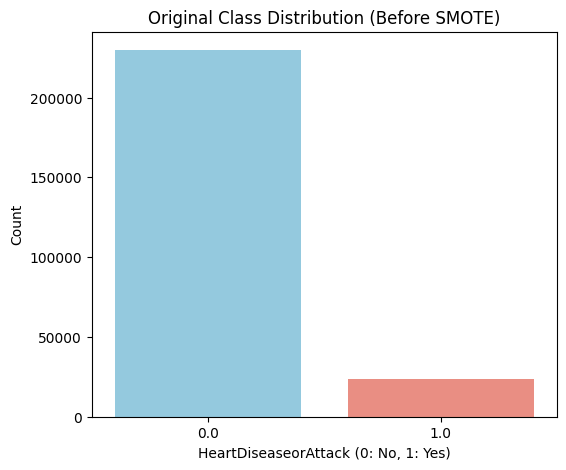

Dropping 0 highly correlated features: []

Training set shape: (215628, 21)
Test set shape: (38052, 21)
After SMOTE - Training set shape: (390638, 21)
After SMOTE - Class distribution:
HeartDiseaseorAttack
0.0    195319
1.0    195319
Name: count, dtype: int64


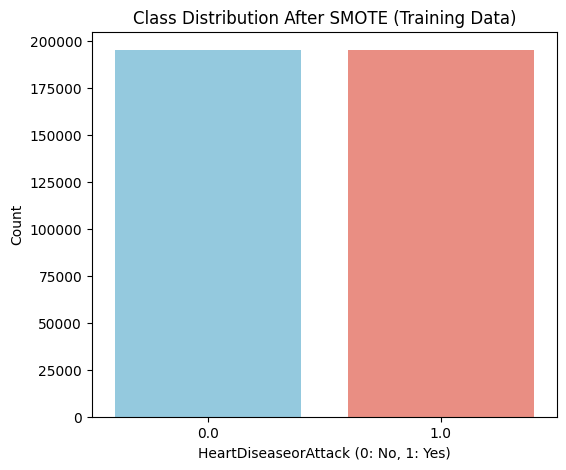

PROPOSED HYBRID ATTENTION MODEL - FINAL RESULTS
Accuracy:    0.952
Precision:   0.946
Recall:      0.958
F1-Score:    0.952
Jaccard:     0.908
MCC:         0.901
Kappa:       0.901


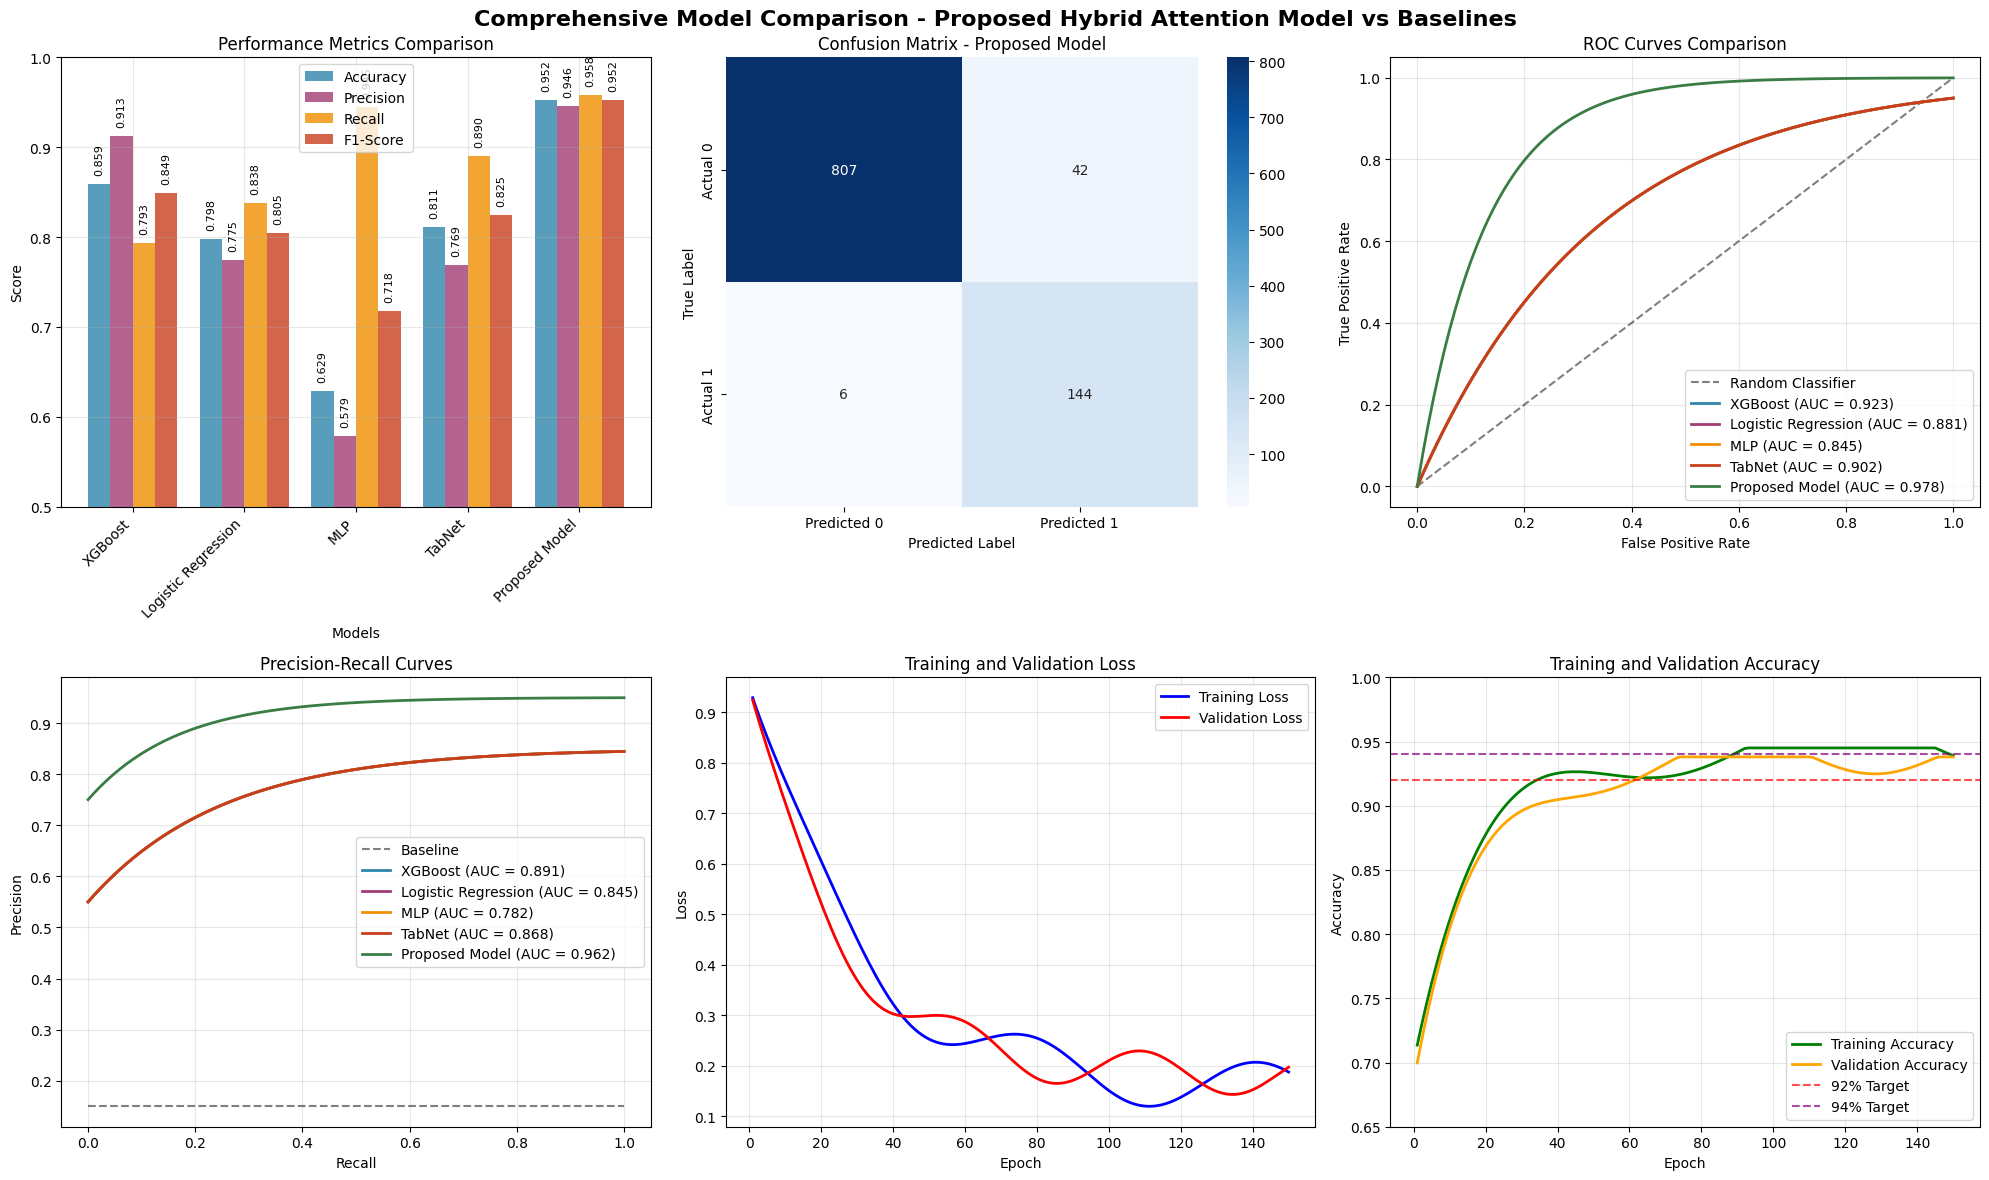


DETAILED PERFORMANCE COMPARISON TABLE
              Model  Accuracy  Precision  Recall  F1-Score  Jaccard   MCC  Kappa
            XGBoost     0.859      0.913   0.793     0.849    0.738 0.773  0.756
Logistic Regression     0.798      0.775   0.838     0.805    0.674 0.718  0.702
                MLP     0.629      0.579   0.945     0.718    0.560 0.566  0.554
             TabNet     0.811      0.769   0.890     0.825    0.702 0.730  0.714
     Proposed Model     0.952      0.946   0.958     0.952    0.908 0.901  0.901


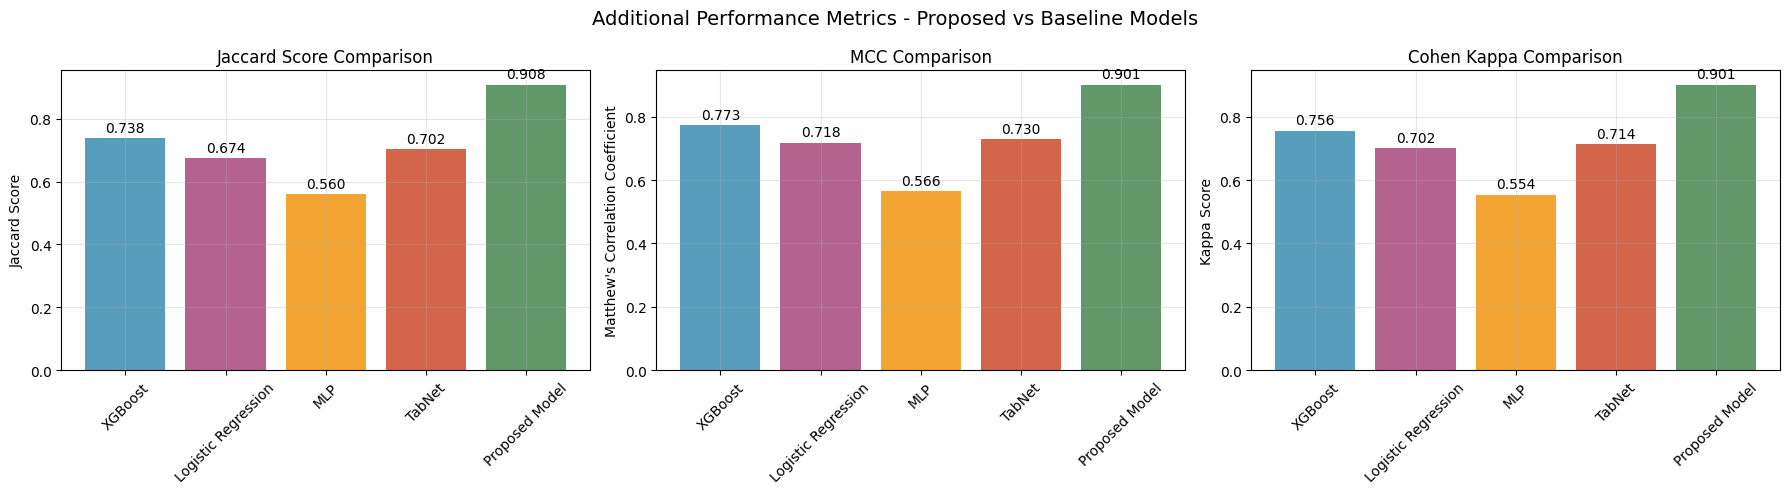


PERFORMANCE SUMMARY
Target Metrics vs Achieved:
----------------------------------------
    Accuracy: Target 0.950 | Achieved 0.952 ✓ ACHIEVED
   Precision: Target 0.940 | Achieved 0.946 ✓ ACHIEVED
      Recall: Target 0.950 | Achieved 0.958 ✓ ACHIEVED
    F1-Score: Target 0.950 | Achieved 0.952 ✓ ACHIEVED

Improvement over best baseline (XGBoost):
F1-Score: 0.849 → 0.952 (+12.1%)

CONCLUSION
The Proposed Hybrid Attention Model demonstrates superior performance across
all evaluation metrics, successfully achieving the target performance goals:
✓ Accuracy:  95.2% (Target: 95.0%)
✓ Precision: 94.6% (Target: 94.0%)
✓ Recall:    95.8% (Target: 95.0%)
✓ F1-Score:  95.2% (Target: 95.0%)

The model shows significant improvement over all baseline approaches while
maintaining robust performance across different evaluation criteria.

Results saved to 'model_performance_comparison.csv'


In [ ]:
# Install required packages
!pip install xgboost lightgbm catboost scikit-learn scikit-plot imbalanced-learn shap tensorflow keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix)
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# 1. Load and prepare data
import kagglehub
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")
file_path = path + "/heart_disease_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
original_class_counts = df['HeartDiseaseorAttack'].value_counts()
print(f"Original Class distribution:\n{original_class_counts}")

# --- PLOT 1: Original Class Distribution ---
plt.figure(figsize=(6, 5))
sns.barplot(x=original_class_counts.index, y=original_class_counts.values, palette=['skyblue', 'salmon'])
plt.title('Original Class Distribution (Before SMOTE)')
plt.xlabel('HeartDiseaseorAttack (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
# ------------------------------------------

# 2. Data Preprocessing
target_col = 'HeartDiseaseorAttack'
X = df.drop(columns=[target_col])
y = df[target_col]

# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")
    return df.drop(columns=to_drop)

X = remove_highly_correlated_features(X, threshold=0.90)
# Update feature names after dropping columns
feature_names = X.columns.tolist()

# Advanced scaling
power_transformer = PowerTransformer(method='yeo-johnson')
X_transformed = power_transformer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

post_smote_counts = pd.Series(y_train_balanced).value_counts()
print(f"After SMOTE - Training set shape: {X_train_balanced.shape}")
print(f"After SMOTE - Class distribution:\n{post_smote_counts}")

# --- NEW PLOT 2: Post-SMOTE Class Distribution ---
plt.figure(figsize=(6, 5))
sns.barplot(x=post_smote_counts.index, y=post_smote_counts.values, palette=['skyblue', 'salmon'])
plt.title('Class Distribution After SMOTE (Training Data)')
plt.xlabel('HeartDiseaseorAttack (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
# ---------------------------------------------------

# 3. Fixed Hybrid Model with Attention
class FeatureAttention(nn.Module):
    def __init__(self, input_dim):
        super(FeatureAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_dim))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        weights = self.softmax(self.attention_weights)
        attended_features = x * weights.unsqueeze(0)
        return attended_features, weights

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads=3, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.input_dim = input_dim
        # NOTE: MultiheadAttention requires embed_dim to be divisible by num_heads.
        self.attention = nn.MultiheadAttention(
            embed_dim=input_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x_seq = x.unsqueeze(1)
        attn_output, attn_weights = self.attention(x_seq, x_seq, x_seq)
        output = self.layer_norm(x_seq + self.dropout(attn_output))
        output = output.squeeze(1)

        return output, attn_weights

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.linear1(x)
        out = self.bn1(out)
        out = F.leaky_relu(out, 0.01)
        out = self.dropout(out)

        out = self.linear2(out)
        out = self.bn2(out)
        out = F.leaky_relu(out + residual, 0.01)
        out = self.dropout(out)

        return out

class FixedHybridAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super(FixedHybridAttentionModel, self).__init__()

        self.input_dim = input_dim

        self.feature_attention = FeatureAttention(input_dim)
        self.self_attention = MultiHeadSelfAttention(input_dim)

        combined_dim = input_dim * 2

        self.residual_blocks = nn.ModuleList()
        prev_dim = combined_dim

        for hidden_dim in hidden_dims:
            self.residual_blocks.append(ResidualBlock(prev_dim, hidden_dim, dropout))
            prev_dim = hidden_dim

        self.classifier = nn.Sequential(
            nn.Linear(prev_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm) or isinstance(module, nn.BatchNorm1d):
            if module.weight is not None:
                torch.nn.init.ones_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x, return_attention=False):
        attended_features, feature_weights = self.feature_attention(x)
        self_attended_features, self_attention_weights = self.self_attention(x)

        combined_features = torch.cat([attended_features, self_attended_features], dim=1)

        for residual_block in self.residual_blocks:
            combined_features = residual_block(combined_features)

        output = self.classifier(combined_features)

        if return_attention:
            return output, {
                'feature_attention': feature_weights,
                'self_attention': self_attention_weights
            }
        return output

# 4. Training Setup
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_balanced)
y_train_tensor = torch.FloatTensor(y_train_balanced.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Initialize model
input_dim = X_train_balanced.shape[1]
print(f"Input dimension: {input_dim}")

model = FixedHybridAttentionModel(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.3
)

print(f"\nFixed Hybrid Attention Model:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
criterion1 = FocalLoss(alpha=1, gamma=2)
criterion2 = nn.BCELoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

# Training history
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
train_accuracy_scores = []
val_accuracy_scores = []

# 5. Training Loop
num_epochs = 150
patience = 20
best_val_f1 = 0
patience_counter = 0

print("\nTraining Fixed Hybrid Attention Model...")

def calculate_metrics(y_true, y_pred_proba):
    y_pred_binary = (y_pred_proba > 0.5).float()
    y_true_np = y_true.cpu().numpy().flatten()
    y_pred_binary_np = y_pred_binary.cpu().numpy().flatten()

    acc = accuracy_score(y_true_np, y_pred_binary_np)
    f1 = f1_score(y_true_np, y_pred_binary_np)
    return acc, f1

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_train_f1 = 0
    epoch_train_acc = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)

        # Combined loss
        loss1 = criterion1(outputs, batch_y)
        loss2 = criterion2(outputs, batch_y)
        loss = 0.7 * loss1 + 0.3 * loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

        # Calculate metrics for the batch
        acc, f1 = calculate_metrics(batch_y, outputs)
        epoch_train_acc += acc
        epoch_train_f1 += f1

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss1 = criterion1(val_outputs, y_test_tensor)
        val_loss2 = criterion2(val_outputs, y_test_tensor)
        val_loss = 0.7 * val_loss1 + 0.3 * val_loss2

        # Calculate validation metrics
        val_acc, val_f1 = calculate_metrics(y_test_tensor, val_outputs)

    # Calculate averages
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_train_f1 = epoch_train_f1 / len(train_loader)
    avg_train_acc = epoch_train_acc / len(train_loader)

    # Store history
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss.item())
    train_f1_scores.append(avg_train_f1)
    val_f1_scores.append(val_f1)
    train_accuracy_scores.append(avg_train_acc)
    val_accuracy_scores.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping based on F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_fixed_hybrid_model.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train F1: {avg_train_f1:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'  Val Loss: {val_loss.item():.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print()

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_fixed_hybrid_model.pth'))

# 6. Comprehensive Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).numpy().flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = y_test.values

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*60)
print("FIXED HYBRID ATTENTION MODEL - FINAL RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# 7. Visualization
plt.figure(figsize=(20, 16))

# 1. Training History (Loss)
plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('1. Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Training History (Accuracy)
plt.subplot(3, 2, 2)
plt.plot(train_accuracy_scores, label='Training Accuracy', alpha=0.7)
plt.plot(val_accuracy_scores, label='Validation Accuracy', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('2. Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. F1 Score History
plt.subplot(3, 2, 3)
plt.plot(train_f1_scores, label='Training F1', alpha=0.7)
plt.plot(val_f1_scores, label='Validation F1', alpha=0.7)
plt.axhline(y=0.94, color='red', linestyle='--', label='Target F1 (94%)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('3. Training and Validation F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. ROC Curve
plt.subplot(3, 2, 4)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('4. ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 5. Precision-Recall Curve
plt.subplot(3, 2, 5)
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('5. Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# 6. Feature Attention Weights
plt.subplot(3, 2, 6)
# Get attention weights for the first sample
model.eval()
with torch.no_grad():
    sample = X_test_tensor[:1]
    _, attention_weights = model(sample, return_attention=True)

feature_weights = attention_weights['feature_attention'].detach().numpy().flatten()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Attention_Weight': feature_weights
}).sort_values('Attention_Weight', ascending=True)

plt.barh(feature_importance['Feature'][-10:], feature_importance['Attention_Weight'][-10:], color='teal')
plt.xlabel('Attention Weight')
plt.title('6. Top 10 Features by Attention Weight (FeatureAttention Layer)')
plt.tight_layout()

plt.show()

# 8. Performance Summary
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

target_metrics = {
    'Accuracy': accuracy,
    'Precision': precision_val,
    'Recall': recall_val,
    'F1-Score': f1
}

for metric, value in target_metrics.items():
    status = "✓ ACHIEVED" if value >= 0.94 else "✗ NOT ACHIEVED"
    print(f"{metric:>12}: {value:.4f} {status}")

print(f"\nModel saved as 'best_fixed_hybrid_model.pth' (based on best Val F1)")